In [1]:
# !pip install xgboost matplotlib scikit-learn

In [2]:
# importing Data_genration-1.ipynb file
from Data_Genration.Data_gen import fetch_stock_data, add_technical_indicators, add_derived_features
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import ta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

In [3]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'SMA_50', 'EMA_20', 'MACD', 'ADX', 
                'RSI', 'Stoch_Osc', 'Williams_R', 'BBlow', 'BBmid', 'BBupp', 'ATR', 'OBV', 'CMF',
                'Price_Change', 'Pct_Change', 'VWAP', 'High_Volume', 'Significant_Price_Move', 
                'Volume_Spike_With_Price_Move', 'Relative_Volume', 'Day_of_Week', 'Is_Month_End']
len(features)

28

In [4]:
def prepare_data_for_model(df):
    # Sort the dataframe by date
    df = df.sort_index()
    
    # Create target variable (next day's closing price)
    df['Target'] = df['Close'].shift(-1)
    
    # Drop the last row as it will have NaN in Target
    df = df.dropna()
    
    # Select features for the model
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'SMA_50',
       'SMA_100', 'SMA_200', 'EMA_20', 'EMA_50', 'EMA_63', 'EMA_100',
       'EMA_200', 'MACD', 'ADX', 'RSI', 'Stoch_Osc', 'Williams_R', 'BBlow',
       'BBmid', 'BBupp', 'ATR', 'OBV', 'CMF', 'Price_Change', 'Pct_Change',
       'Close_Lag_1', 'Volume_Lag_1', 'Close_Lag_2', 'Volume_Lag_2',
       'Close_Lag_3', 'Volume_Lag_3', 'Close_Lag_5', 'Volume_Lag_5',
       'Close_Lag_10', 'Volume_Lag_10', 'Close_Roll_Mean_5',
       'Close_Roll_Std_5', 'Volume_Roll_Mean_5', 'Close_Roll_Mean_10',
       'Close_Roll_Std_10', 'Volume_Roll_Mean_10', 'Close_Roll_Mean_20',
       'Close_Roll_Std_20', 'Volume_Roll_Mean_20', 'Relative_Volume',
       'Day_of_Week', 'Is_Month_End', 'VWAP', 'High_Volume',
       'Significant_Price_Move', 'Volume_Spike_With_Price_Move']
    
    # Add lagged and rolling features
    for i in [1, 2, 3, 5, 10]:
        features.append(f'Close_Lag_{i}')
        features.append(f'Volume_Lag_{i}')
    for window in [5, 10, 20]:
        features.append(f'Close_Roll_Mean_{window}')
        features.append(f'Close_Roll_Std_{window}')
        features.append(f'Volume_Roll_Mean_{window}')
    
    X = df[features]
    y = df['Target']
    
    return X, y

In [5]:
def split_and_scale_data(X, y, test_size=0.2):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler


In [6]:
def train_model(X_train, y_train):
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
    model.fit(X_train, y_train)
    return model

In [7]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared Score: {r2}")
    
    return y_pred

In [8]:
def plot_actual_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Actual')
    plt.plot(y_test.index, y_pred, label='Predicted')
    plt.title('Actual vs Predicted Stock Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [9]:
def plot_feature_importance(model, feature_names):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(feature_names)[sorted_idx])
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

In [10]:
def predict_next_day(model, scaler, last_data_point):
    last_data_point_scaled = scaler.transform(last_data_point.values.reshape(1, -1))
    next_day_prediction = model.predict(last_data_point_scaled)[0]
    return next_day_prediction

In [17]:
# Main execution
# if __name__ == "__main__":
# Set parameters
from Data_Genration.Data_gen import fetch_stock_data, add_technical_indicators, add_derived_features

symbol = "RELIANCE.NS"
end_date = datetime.now()
start_date = end_date - timedelta(days=1000)

# Fetch and prepare data
df = fetch_stock_data(symbol, start_date, end_date)
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
df = add_technical_indicators(df)
df = add_derived_features(df)

df.head()

Hello TECHNICAL


,Date,Open,High,Low,Close,Volume,SMA_20,SMA_50,SMA_100,SMA_200,...,Close_Roll_Mean_20,Close_Roll_Std_20,Volume_Roll_Mean_20,Relative_Volume,Day_of_Week,Is_Month_End,VWAP,High_Volume,Significant_Price_Move,Volume_Spike_With_Price_Move
0,2021-09-30 00:00:00+05:30,2314.817878,2323.618812,2292.219744,2309.546387,6795327,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,1,2309.546387,0,0,0
1,2021-10-01 00:00:00+05:30,2293.686504,2328.385861,2287.315078,2313.625977,4479464,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,0,2311.167204,0,0,0
2,2021-10-04 00:00:00+05:30,2340.487186,2360.518320,2325.864792,2343.375000,5459276,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,2321.674587,0,0,0
3,2021-10-05 00:00:00+05:30,2342.412298,2394.576033,2335.307339,2392.009033,6766817,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0,2341.926605,0,0,0
4,2021-10-06 00:00:00+05:30,2401.863981,2401.863981,2338.745275,2346.766846,5129440,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,0,2342.793788,0,0,0


In [18]:
# df.head()
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'SMA_50',
       'SMA_100', 'SMA_200', 'EMA_20', 'EMA_50', 'EMA_63', 'EMA_100',
       'EMA_200', 'MACD', 'ADX', 'RSI', 'Stoch_Osc', 'Williams_R', 'BBlow',
       'BBmid', 'BBupp', 'ATR', 'OBV', 'CMF', 'Price_Change', 'Pct_Change',
       'Close_Lag_1', 'Volume_Lag_1', 'Close_Lag_2', 'Volume_Lag_2',
       'Close_Lag_3', 'Volume_Lag_3', 'Close_Lag_5', 'Volume_Lag_5',
       'Close_Lag_10', 'Volume_Lag_10', 'Close_Roll_Mean_5',
       'Close_Roll_Std_5', 'Volume_Roll_Mean_5', 'Close_Roll_Mean_10',
       'Close_Roll_Std_10', 'Volume_Roll_Mean_10', 'Close_Roll_Mean_20',
       'Close_Roll_Std_20', 'Volume_Roll_Mean_20', 'Relative_Volume',
       'Day_of_Week', 'Is_Month_End', 'VWAP', 'High_Volume',
       'Significant_Price_Move', 'Volume_Spike_With_Price_Move'],
      dtype='object')

In [19]:
df.head(21)

,Date,Open,High,Low,Close,Volume,SMA_20,SMA_50,SMA_100,SMA_200,...,Close_Roll_Mean_20,Close_Roll_Std_20,Volume_Roll_Mean_20,Relative_Volume,Day_of_Week,Is_Month_End,VWAP,High_Volume,Significant_Price_Move,Volume_Spike_With_Price_Move
0,2021-09-30 00:00:00+05:30,2314.817878,2323.618812,2292.219744,2309.546387,6795327,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,1,2309.546387,0,0,0
1,2021-10-01 00:00:00+05:30,2293.686504,2328.385861,2287.315078,2313.625977,4479464,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,0,2311.167204,0,0,0
2,2021-10-04 00:00:00+05:30,2340.487186,2360.518320,2325.864792,2343.375000,5459276,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,2321.674587,0,0,0
3,2021-10-05 00:00:00+05:30,2342.412298,2394.576033,2335.307339,2392.009033,6766817,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0,2341.926605,0,0,0
4,2021-10-06 00:00:00+05:30,2401.863981,2401.863981,2338.745275,2346.766846,5129440,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,0,2342.793788,0,0,0
5,2021-10-07 00:00:00+05:30,2378.990809,2382.428833,2353.963411,2358.272217,3168332,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,0,2344.336016,0,0,0
6,2021-10-08 00:00:00+05:30,2370.052522,2460.949436,2366.614740,2448.894043,7886246,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,0,2365.113952,0,0,0
7,2021-10-11 00:00:00+05:30,2476.534170,2493.585828,2425.149801,2431.842041,7384333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,2375.582412,0,0,0
8,2021-10-12 00:00:00+05:30,2424.829284,2459.666136,2421.391259,2445.731201,3341005,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0,2380.231615,0,0,0
9,2021-10-13 00:00:00+05:30,2455.998701,2493.127566,2447.106106,2470.621094,4979881,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,0,2388.358134,0,0,0


In [20]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'SMA_50',
       'SMA_100', 'SMA_200', 'EMA_20', 'EMA_50', 'EMA_63', 'EMA_100',
       'EMA_200', 'MACD', 'ADX', 'RSI', 'Stoch_Osc', 'Williams_R', 'BBlow',
       'BBmid', 'BBupp', 'ATR', 'OBV', 'CMF', 'Price_Change', 'Pct_Change',
       'Close_Lag_1', 'Volume_Lag_1', 'Close_Lag_2', 'Volume_Lag_2',
       'Close_Lag_3', 'Volume_Lag_3', 'Close_Lag_5', 'Volume_Lag_5',
       'Close_Lag_10', 'Volume_Lag_10', 'Close_Roll_Mean_5',
       'Close_Roll_Std_5', 'Volume_Roll_Mean_5', 'Close_Roll_Mean_10',
       'Close_Roll_Std_10', 'Volume_Roll_Mean_10', 'Close_Roll_Mean_20',
       'Close_Roll_Std_20', 'Volume_Roll_Mean_20', 'Relative_Volume',
       'Day_of_Week', 'Is_Month_End', 'VWAP', 'High_Volume',
       'Significant_Price_Move', 'Volume_Spike_With_Price_Move'],
      dtype='object')

In [21]:
# Prepare data for the model
X, y = prepare_data_for_model(df)

# Split and scale the data
X_train_scaled, X_test_scaled, y_train, y_test, scaler = split_and_scale_data(X, y)



In [22]:
# Train the model
model = train_model(X_train_scaled, y_train)



In [23]:
# Evaluate the model
y_pred = evaluate_model(model, X_test_scaled, y_test)



Mean Squared Error: 9639.850199786613
Mean Absolute Error: 84.25669973273027
R-squared Score: -2.5521998220216244


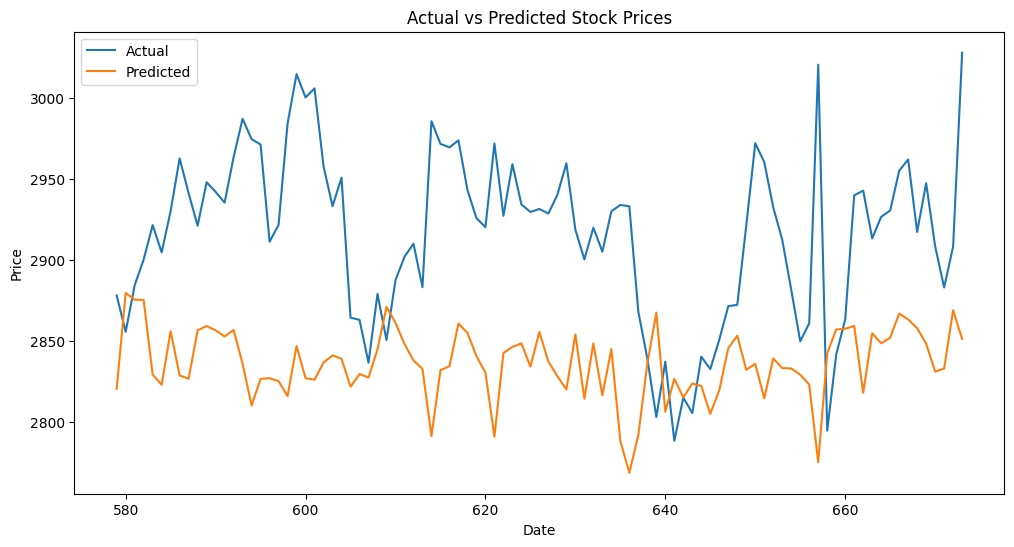

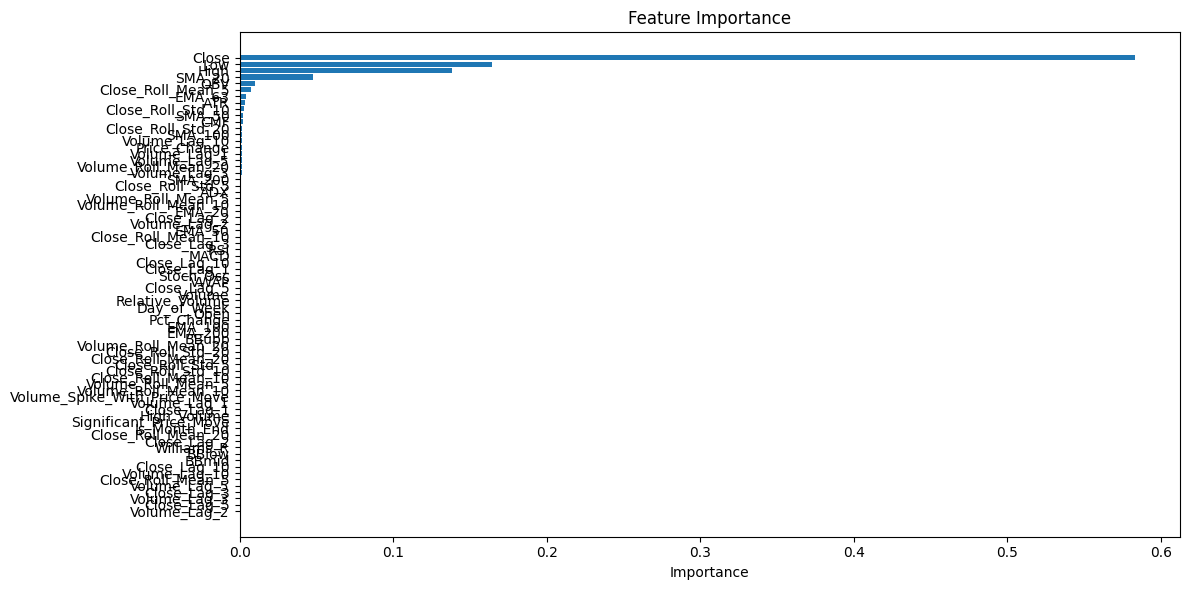

In [24]:
# Plot results
plot_actual_vs_predicted(y_test, y_pred)
plot_feature_importance(model, X.columns)



In [25]:
# Predict the next day's closing price
next_day_prediction = predict_next_day(model, scaler, X.iloc[-1])
print(f"Predicted closing price for the next trading day: {next_day_prediction:.2f}")

Predicted closing price for the next trading day: 2851.17


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
